<a href="https://colab.research.google.com/github/RudyMartin/yelp/blob/main/YelpReviews_4_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rudy Martin <realrudymartin@gmail.com> (2025-01-07)

# Topic Trends

This notebook is part of a series to analyze the differences between pre-pandemic and post-pandemic Yelp reviews reflect changes in user behavior or writing styles.


In our initial work we. covered sentiment analysis to assess whether user attitudes shifted significantly. See part 1 workbook for those details.

The workbook documents our approach to topic including:

1. Examine Word Usage Patterns: Perform text analysis to compare common words, word counts, and themes.

2. Review Length Distributions:  Compare distributions of review lengths for pre- and post-pandemic reviews.

3. Topic Modeling: Identify if topics discussed in reviews changed significantly across the periods.



In [1]:
# [1] Import necessary libraries

# Add directory to the system's path
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import google.generativeai as genai
import os
import sys
from datetime import datetime
from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# [2] API configuration and system path setup. - place in secrets later
sys.path.append('/content/drive/My Drive/yelp/')


In [2]:
# [3] Data Loading
drive.mount("/content/drive", force_remount=True)
data_dir = '/content/drive/My Drive/yelp/'
data_path = f'{data_dir}Yelp Restaurant Reviews.csv'
try:
    data = pd.read_csv(data_path)
    print("Dataset loaded successfully. Columns:", data.columns)
except FileNotFoundError:
    print("Error: Dataset not found. Please check the path.")

# [4] Data Preprocessing
data['Date'] = pd.to_datetime(data['Date'])

# for cost/time reasons just focus on the two years before and the year after March 2020 (see ratings history notebook for details)
data = data[(data['Date'] >= '2018-03-01') & (data['Date'] <= '2022-02-28')]  # Limiting data around March 2020

data['Year'], data['Month'] = data['Date'].dt.year, data['Date'].dt.month
data['Pre_March_2020'] = data['Date'] < datetime(2020, 3, 1)
data['Polarity'] = data['Review Text'].apply(lambda text: TextBlob(text).sentiment.polarity)
data['Sentiment'] = data['Polarity'].apply(lambda x: 'Positive' if x > 0.1 else 'Negative' if x < -0.1 else 'Neutral')

# Filter pre- and post-pandemic data
pre_pandemic = data[data['Date'] < '2020-03-01']
post_pandemic = data[data['Date'] >= '2020-03-01']


Mounted at /content/drive
Dataset loaded successfully. Columns: Index(['Yelp URL', 'Rating', 'Date', 'Review Text'], dtype='object')


# 1. Word Usage Patterns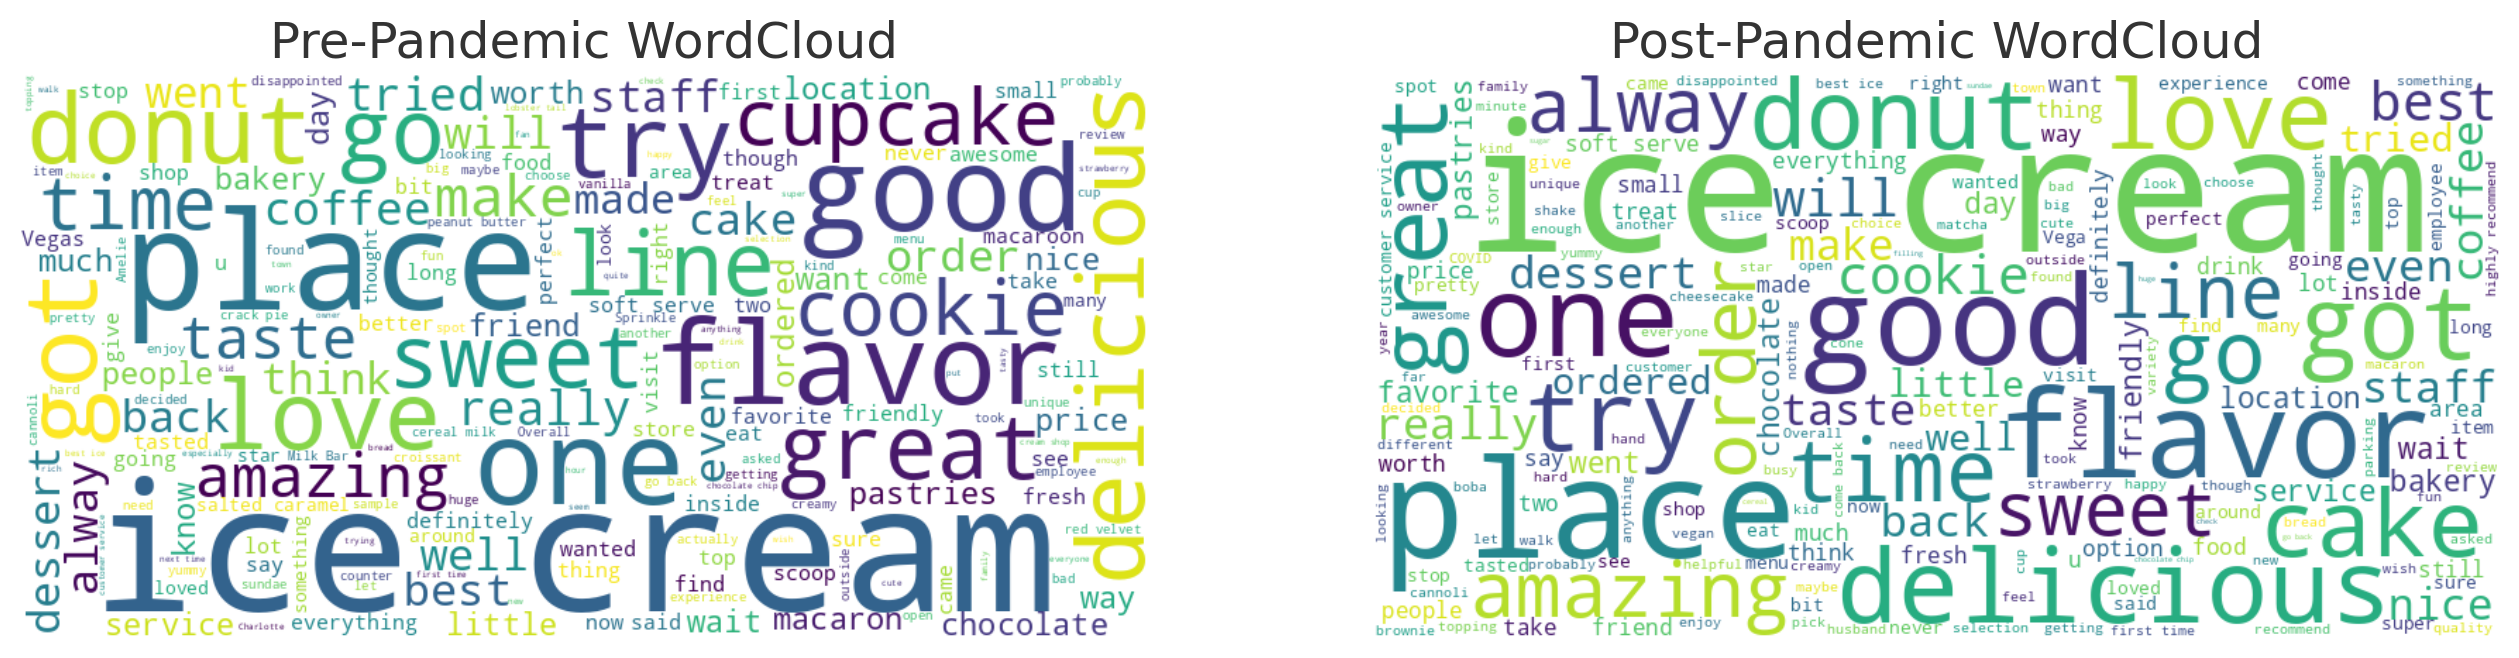

The most basic word cloud shows that the dominant top themes are still the same ones before and after. And our other clustering work suggests that the best cells for analysis may be multi-label. As a step towards that we might consider adding additional metadata features to the observations data.

Here's the first one : a meal variable

### Meal-Related Keyword Trends



Key Points:

* General Dominance: A large number of reviews remain categorized under "General," reflecting high-level sentiments or non-specific discussions.
* Beverages Subcategory:
Pre-Pandemic: 376 reviews explicitly mention beverages.
Post-Pandemic: 152 reviews focus on beverages, possibly due to reduced dine-in coffee culture during the pandemic.
* Unclassified Reviews: A significant number of reviews remain unclassified, indicating opportunities to refine keywords further or analyze them separately.
* There are no posting timestamps in the data so "meal_time" is not available as a proximity to the event indicator.

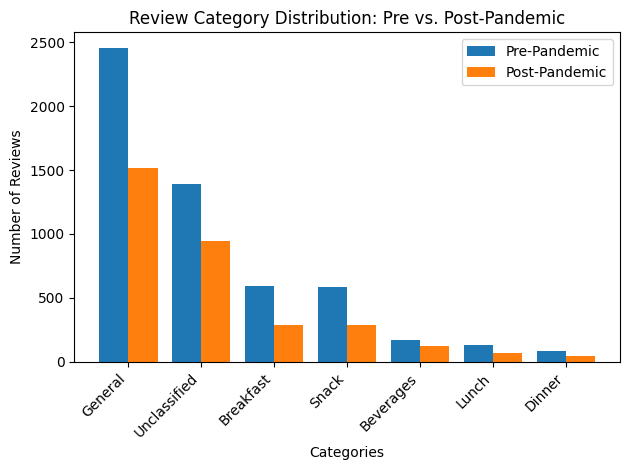

In [5]:
# Meal-Related Keyword Trends

# Define categories and keywords
categories = {
    "Breakfast": {"pancakes", "eggs", "coffee", "croissant", "toast", "omelette", "brunch", "bacon", "morning", "waffle"},
    "Lunch": {"sandwich", "burger", "salad", "fries", "wrap", "soup", "noon", "lunch", "bowl", "chips"},
    "Dinner": {"steak", "pasta", "seafood", "wine", "dinner", "pizza", "chicken", "grill", "evening", "supper"},
    "Snack": {"ice cream", "cookie", "brownie", "popcorn", "donut", "chips", "cracker", "nuts", "pretzel", "snack"},
    "General": {"great", "delicious", "amazing", "food", "service", "restaurant", "menu", "place", "experience", "tasty"},
    "Beverages": {"coffee", "tea", "latte", "espresso", "milkshake", "smoothie", "juice", "mocha", "cappuccino", "drink"}
}

# Function to assign categories
def assign_subcategories(review, categories):
    review_words = set(review.lower().split())
    category_matches = {key: 0 for key in categories.keys()}

    # Count matches for each category
    for category, keywords in categories.items():
        category_matches[category] = len(review_words & keywords)

    # Assign the category with the most matches, or "Unclassified" if no matches
    assigned_category = max(category_matches, key=category_matches.get)
    if category_matches[assigned_category] == 0:
        assigned_category = "Unclassified"

    return assigned_category

# Load pre-processed pre- and post-pandemic datasets (Ensure the dataset is loaded as shown earlier)
# Apply the updated categorization function with .loc[] to avoid slice warnings
pre_pandemic.loc[:, "UpdatedCategory"] = pre_pandemic["Review Text"].apply(lambda x: assign_subcategories(x, categories))
post_pandemic.loc[:, "UpdatedCategory"] = post_pandemic["Review Text"].apply(lambda x: assign_subcategories(x, categories))

# Count the distribution of categories
pre_category_counts = pre_pandemic["UpdatedCategory"].value_counts()
post_category_counts = post_pandemic["UpdatedCategory"].value_counts()


# Visualization
def plot_category_distributions(pre_counts, post_counts, title):
    labels = pre_counts.index
    x = range(len(labels))
    pre_values = pre_counts.values
    post_values = post_counts.reindex(labels).fillna(0).values

    plt.bar(x, pre_values, width=0.4, label='Pre-Pandemic', align='center')
    plt.bar([p + 0.4 for p in x], post_values, width=0.4, label='Post-Pandemic', align='center')
    plt.xticks([p + 0.2 for p in x], labels, rotation=45, ha='right')
    plt.xlabel("Categories")
    plt.ylabel("Number of Reviews")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot results
plot_category_distributions(pre_category_counts, post_category_counts, "Review Category Distribution: Pre vs. Post-Pandemic")


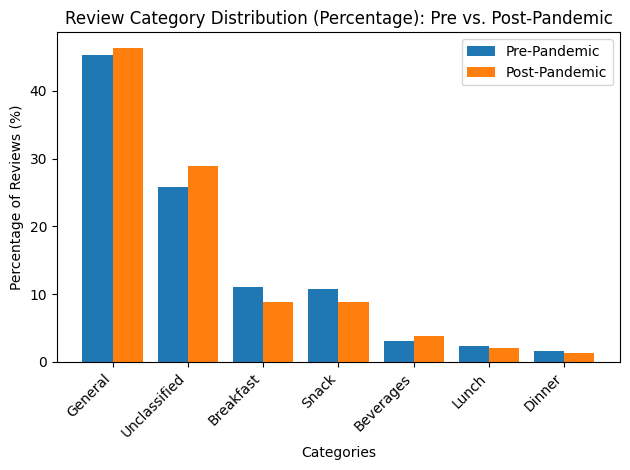

In [6]:
def plot_category_distributions_percentage(pre_counts, post_counts, title):
    # Calculate percentages
    pre_percentages = (pre_counts / pre_counts.sum()) * 100
    post_percentages = (post_counts / post_counts.sum()) * 100

    # Align labels
    labels = pre_percentages.index
    x = range(len(labels))
    post_percentages = post_percentages.reindex(labels).fillna(0)

    # Plot percentages
    plt.bar(x, pre_percentages, width=0.4, label='Pre-Pandemic', align='center')
    plt.bar([p + 0.4 for p in x], post_percentages, width=0.4, label='Post-Pandemic', align='center')
    plt.xticks([p + 0.2 for p in x], labels, rotation=45, ha='right')
    plt.xlabel("Categories")
    plt.ylabel("Percentage of Reviews (%)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot results as percentages
plot_category_distributions_percentage(pre_category_counts, post_category_counts, "Review Category Distribution (Percentage): Pre vs. Post-Pandemic")


Observation:
* Post-pandemic it appears that non-menu items such as service and customer experience are more important.

### Pandemic-Related Keyword Trends

Key Points:

* Emerging Concerns: "Sanitized" or "mask" might spike in early 2020 and decline in 2022.
* Service Adaptations: "Curbside" might rise in 2020 and remain a common practice afterward.
* Temporary Issues: "Shortage" or "out of stock" might fade post-2021.


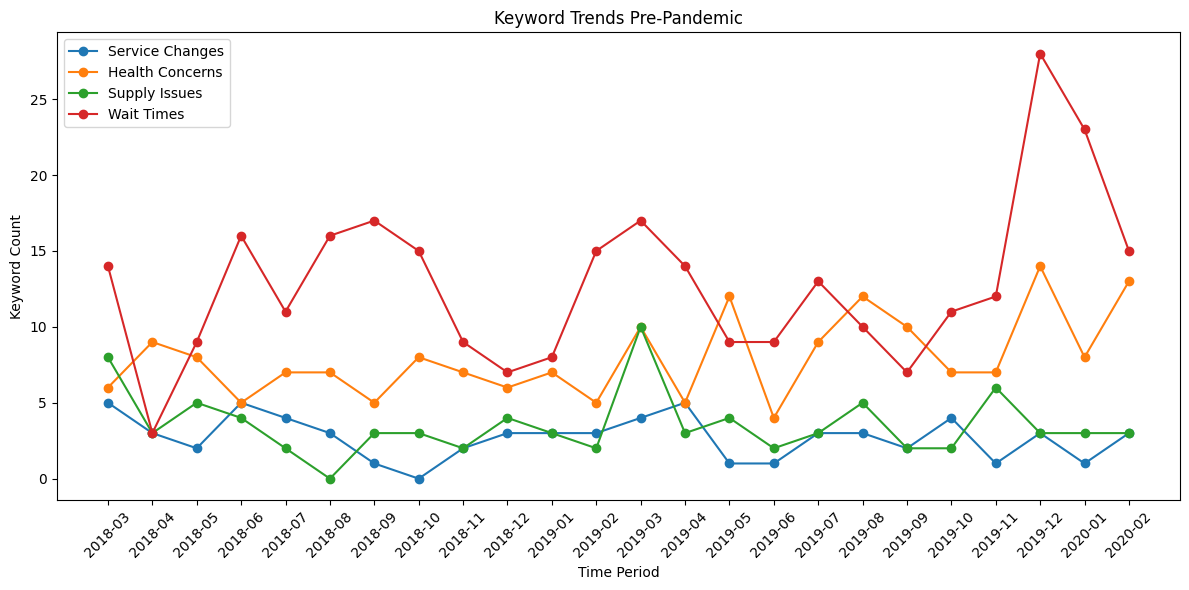

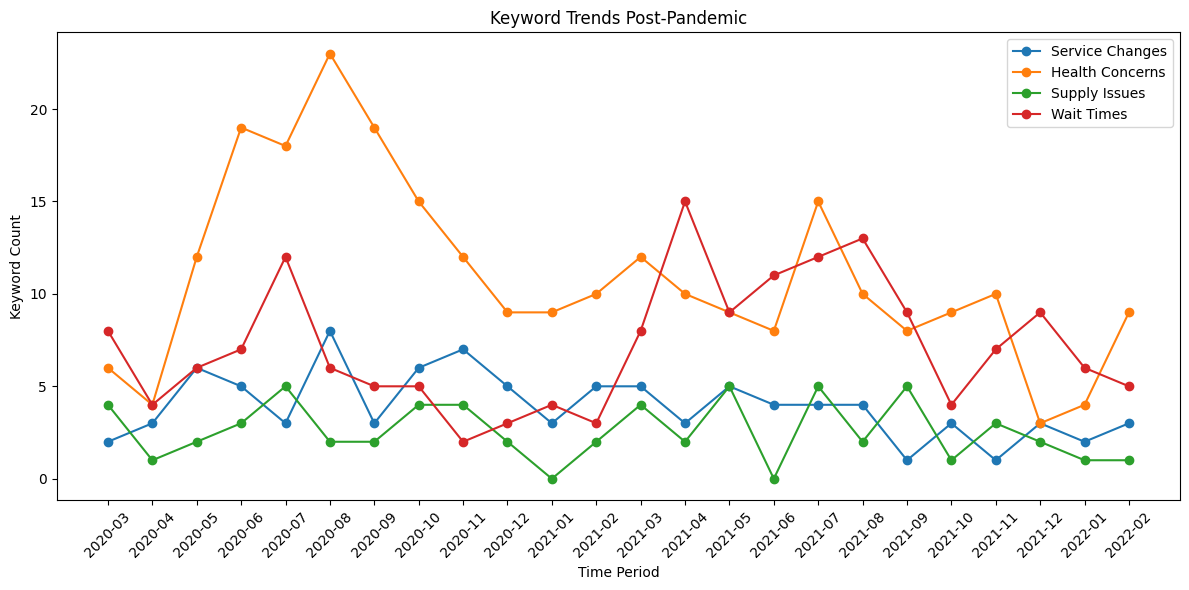

In [10]:
# Define pandemic-specific and general keywords
pandemic_keywords = {
    "Service Changes": {"takeout", "curbside", "delivery", "pickup", "online"},
    "Health Concerns": {"clean", "sanitized", "mask", "distance", "safe"},
    "Supply Issues": {"shortage", "out of stock", "limited"},
    "Wait Times": {"long wait", "crowded", "busy", "delay", "slow"}
}

# Function to count keyword occurrences by category over time
def count_keywords_by_time(data, keywords, time_column, text_column, time_interval="M"):
    # Ensure datetime format using .loc[]
    data = data.copy()  # Prevent modifying the original DataFrame
    data.loc[:, time_column] = pd.to_datetime(data[time_column], errors='coerce')
    data = data.dropna(subset=[time_column])  # Drop rows with invalid dates

    # Group data into time periods
    data.loc[:, "Period"] = data[time_column].dt.to_period(time_interval)
    keyword_counts = {key: [] for key in keywords.keys()}
    periods = []

    for period, group in data.groupby("Period"):
        periods.append(str(period))  # Convert Period to string for compatibility
        for category, terms in keywords.items():
            # Count occurrences of keywords in the specified text column
            count = group[text_column].str.contains('|'.join(terms), case=False, na=False).sum()
            keyword_counts[category].append(count)

    return periods, keyword_counts



# Ensure slice warnings are avoided by using .loc[]
pre_pandemic.loc[:, "UpdatedCategory"] = pre_pandemic["Review Text"].apply(lambda x: assign_subcategories(x, categories))
post_pandemic.loc[:, "UpdatedCategory"] = post_pandemic["Review Text"].apply(lambda x: assign_subcategories(x, categories))

# Count keyword occurrences for pre- and post-pandemic data
periods_pre, pre_keyword_counts = count_keywords_by_time(pre_pandemic, pandemic_keywords, "Date", "Review Text")
periods_post, post_keyword_counts = count_keywords_by_time(post_pandemic, pandemic_keywords, "Date", "Review Text")

# Visualization function for keyword trends
def plot_keyword_trends(periods, keyword_counts, title):
    plt.figure(figsize=(12, 6))
    for category, counts in keyword_counts.items():
        plt.plot(periods, counts, marker='o', label=category)

    plt.xlabel("Time Period")
    plt.ylabel("Keyword Count")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot keyword trends for pre-pandemic period
plot_keyword_trends(periods_pre, pre_keyword_counts, "Keyword Trends Pre-Pandemic")

# Plot keyword trends for post-pandemic period
plot_keyword_trends(periods_post, post_keyword_counts, "Keyword Trends Post-Pandemic")


Now let's taKe a closer look based on percentages.

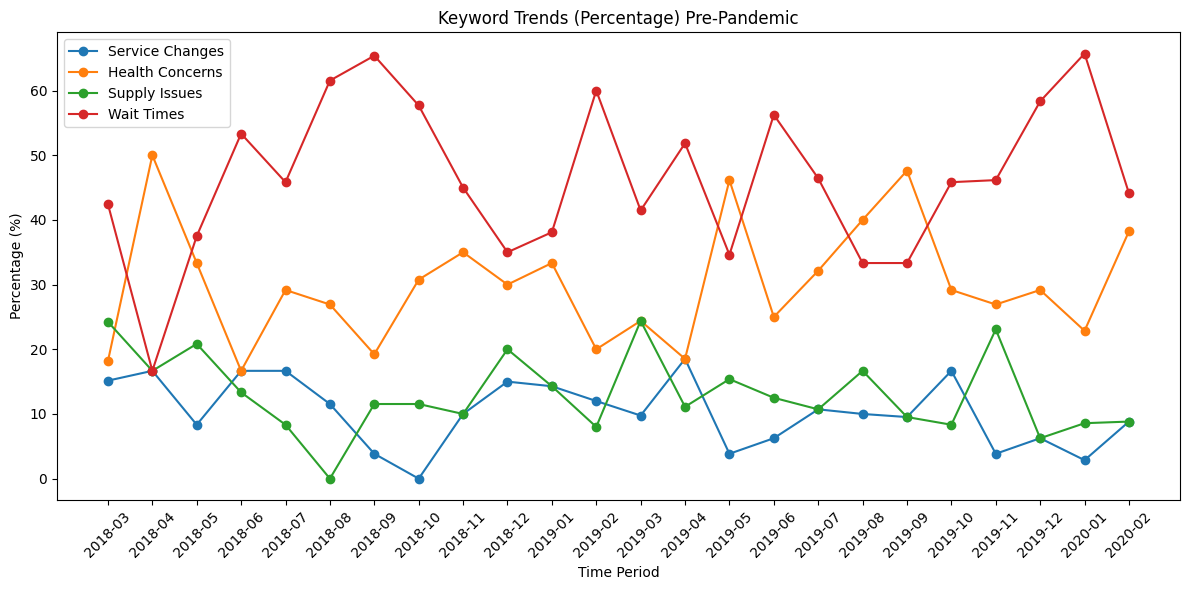

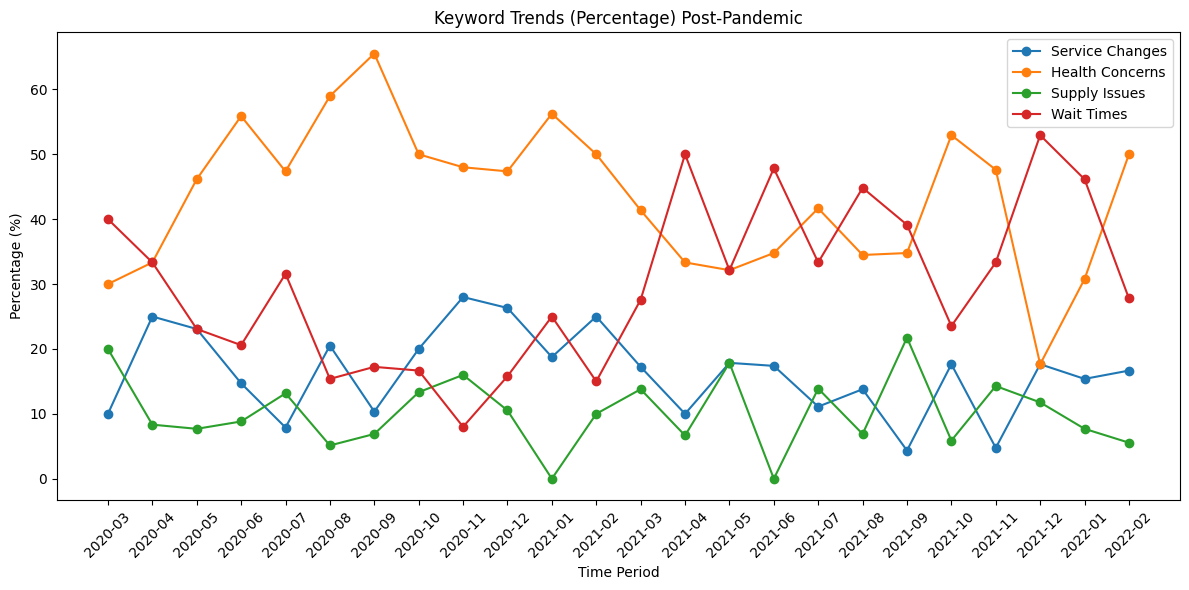

In [11]:
# Visualization function for keyword trends (percentages)
def plot_keyword_trends_percentage(periods, keyword_counts, title):
    # Calculate percentages
    total_counts = [sum(counts) for counts in zip(*keyword_counts.values())]
    percentage_counts = {category: [(count / total * 100 if total > 0 else 0)
                                    for count, total in zip(counts, total_counts)]
                         for category, counts in keyword_counts.items()}

    # Plot percentage trends
    plt.figure(figsize=(12, 6))
    for category, percentages in percentage_counts.items():
        plt.plot(periods, percentages, marker='o', label=category)

    plt.xlabel("Time Period")
    plt.ylabel("Percentage (%)")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot keyword trends as percentages
plot_keyword_trends_percentage(periods_pre, pre_keyword_counts, "Keyword Trends (Percentage) Pre-Pandemic")
plot_keyword_trends_percentage(periods_post, post_keyword_counts, "Keyword Trends (Percentage) Post-Pandemic")


Clearly Health Concerns were the primary customer experience topic. post-pandemic, overtaking the pre-pandemic leading complaint about wait tiems. Note also that post-pandemic service changes were also more relevant than supply issues.

# 2. Review Length Distribution

Ratings 2, 3, 4, and 5 show significant differences, while rating 1 (the most negative). does not exhibit a significant difference.

In [ ]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Create a flag for pre- and post-pandemic reviews
data['Pre_March_2020'] = data['Date'] < pd.Timestamp('2020-03-01')

# Add a feature for review length
data['Review_Length'] = data['Review Text'].str.len()

# Group by rating and pre-/post-pandemic
pre_pandemic = data[data['Pre_March_2020']]
post_pandemic = data[~data['Pre_March_2020']]

# Perform Mann-Whitney U Test for each rating cohort
results = []
for rating in range(1, 6):  # Ratings from 1 to 5
    pre_group = pre_pandemic[pre_pandemic['Rating'] == rating]['Review_Length']
    post_group = post_pandemic[post_pandemic['Rating'] == rating]['Review_Length']

    # Perform Mann-Whitney U Test
    if len(pre_group) > 0 and len(post_group) > 0:  # Ensure both groups have data
        stat, p_value = mannwhitneyu(pre_group, post_group, alternative='two-sided')
        results.append({'Rating': rating, 'Mann-Whitney U': stat, 'p-value': p_value})
    else:
        results.append({'Rating': rating, 'Mann-Whitney U': None, 'p-value': None})

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
results_df


## Mann-Whitney U Test Results

The table below summarizes the results of the Mann-Whitney U test for review length differences between pre-pandemic and post-pandemic reviews, grouped by rating suggesting there is a real difference in writing style.

| Rating | Mann-Whitney U | p-value               |
|--------|----------------|-----------------------|
| 1      | 156739.5       | 0.1644               |
| 2      | 133470.5       | 0.0019 (Significant) |
| 3      | 303833.5       | 0.0002 (Significant) |
| 4      | 1369372.0      | 0.0000 (Significant) |
| 5      | 12466327.5     | 0.0000 (Highly Significant) |


In [ ]:
Mann-Whitney U Test Results:
The table below summarizes the results of the Mann-Whitney U test for review length differences between pre-pandemic and post-pandemic reviews, grouped by rating:

Rating	Mann-Whitney U	p-value
1	156739.5	0.1644
2	133470.5	0.0019 (Significant)
3	303833.5	0.0002 (Significant)
4	1369372.0	0.0000 (Significant)
5	12466327.5	0.0000 (Highly Significant)



### Shorter Review Lengths Lean More Positively

The table below summarizes the counts and average review lengths for each rating cohort, comparing pre-pandemic and post-pandemic periods, along with the percentage difference in average review lengths:

| Rating | Pre-Pandemic Count | Pre-Pandemic Avg Length | Post-Pandemic Count | Post-Pandemic Avg Length | % Difference in Avg Length |
|--------|---------------------|-------------------------|---------------------|--------------------------|----------------------------|
| 1      | 877                 | 566.17                 | 340                 | 513.36                  | -9.33%                    |
| 2      | 1057                | 619.52                 | 223                 | 523.57                  | -15.48%                   |
| 3      | 1766                | 616.57                 | 303                 | 517.19                  | -16.13%                   |
| 4      | 3799                | 573.81                 | 648                 | 486.30                  | -15.23%                   |
| 5      | 8250                | 442.94                 | 2633                | 375.91                  | -15.14%                   |

Interesting that the decline in average length is pretty universally 15-16% except for the negative rankings. So review text is less in the post-pandemic era. This is consistent with more positive sentiment from our exploratory analysis - part 1.

# 3. Next Steps: Additional Topic Modeling

This space reserved for multi-label, multi-class analysis of the clusters using some of the approaches discussed.
